# <center> Basic epidemic models <center>

## Helpers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize
from time import time
from datetime import datetime

In [2]:
# To compute the time to the epidemics peak
def peak(L):
    for i in range(len(L)):
        if L[i+1]<L[i]:
            return i
    return "no peak"

## SIR model

In this first approach, we consider three types of people:

- the __susceptible__ people: they are not immune thus they are likely to be infected
- the __infected__ people: they carry the virus and can infect the susceptible people
- the __recovered__ people: they've already been infected and then they recovered or died. Either case, they can't get infected anymore.

The ODE that we need to solve are as follow:

$$
\left\{
\begin{array}{r c l}
S'(t) & = & -pS(t)I(t) \\
I'(t) & = & pS(t)I(t) - I(t)/d \\
R'(t) & = & I(t)/d
\end{array}
\right.
$$

Where:

- *p* is the __infection rate__: depends on the number of contact between infected and susceptible people, and the probability for a contact to be contagious.
- *d* is the __contagiousness duration__: the number of days people stay contagious.

In [3]:
# SIR model simulation
def SIR(I0, rho, c, d, T):
    p = rho*c # Infection rate
    S, I, R = 1-I0, I0, 0
    S_list, I_list, R_list = [S], [I], [R]
    for i in range(T):
        S, I, R = S - p*S*I, I + p*S*I - I/d, R + I/d
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)
    return S_list, I_list, R_list

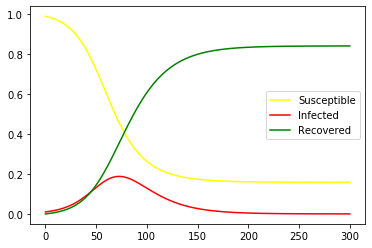

Cumulative number of infected people: 84.1%
Duration before the peak: 73


In [4]:
if __name__ == '__main__':

    # Simulation parameters
    I0 = .01 # Initial number of infected people
    rho = .04 # Probabibility of contagion for an interaction
    c = 3 # Number of contacts per people per day
    d = 18 # Contagiousness duration (days) 
    T = 300 # Study duration (days)

    # Run simulation
    S_list, I_list, R_list = SIR(I0, rho, c, d, T)

    # Plot results
    plt.plot(S_list, label='Susceptible', color='yellow')
    plt.plot(I_list, label='Infected', color='red')
    plt.plot(R_list, label='Recovered', color='green')
    plt.legend()
    plt.show()

    print("Cumulative number of infected people: {}%".format(round(100*R_list[-1], 1)))
    print("Duration before the peak: {}".format(peak(I_list)))

## SEIR model

In this second approach, we consider three types of people:

- the __susceptible__ people: they are not immune thus they are likely to be infected
- the __exposed__ people: they carry the virus but they don't have any symptoms
- the __infected__ people: they carry the virus and can infect the susceptible people, but they know thay are sick as they are enough advanced to have symptoms
- the __recovered__ people: they've already been infected and then they recovered or died. Either case, they can't get infected anymore.

The ODE that we need to solve are as follow:

$$
\left\{
\begin{array}{r c l}
S'(t) & = & -p_eS(t)E(t) - p_iS(t)I(t) \\
E'(t) & = & p_eS(t)E(t) + p_iS(t)I(t) - E(t)/d_e \\
I'(t) & = & E(t)/d_e - I(t)/d_i \\
R'(t) & = & I(t)/d_i
\end{array}
\right.
$$

Where:

- $p_e$ is the __exposition rate__: depends on the number of contact between exposed and susceptible people, and the probability for a contact to be contagious.
- $p_i$ is the __infection rate__: depends on the number of contact between infected and susceptible people, and the probability for a contact to be contagious.
- $d_e$ is the __exposition duration__: the number of days people stay contagious without any symptom.
- $d_i$ is the __infection duration__: the number of days people stay contagious with symptoms.

In [5]:
# SEIR simulation
def SEIR(E0, I0, pe, pi, de, di, T):
    S, E, I, R = 1-E0-I0, E0, I0, 0
    S_list, E_list, I_list, R_list = [S], [E], [I], [R]
    for i in range(T):
        S, E, I, R = S - pe*S*E - pi*S*I, E + pe*S*E + pi*S*I - E/de, I + E/de - I/di, R + I/di
        S_list.append(S)
        E_list.append(E)
        I_list.append(I)
        R_list.append(R)
    return S_list, E_list, I_list, R_list

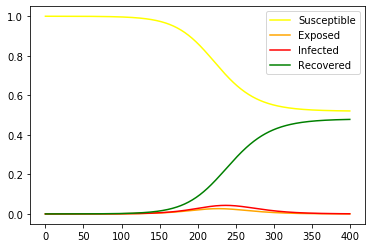

Cumulative number of infected people: 0.47809741537306305
Duration before the peak: 237


In [6]:
if __name__ == '__main__':
    
    # Simulation parameters
    E0 = .000015 # Initial number of exposed people
    I0 = .00001 # Initial number of infected people
    pe = .16
    pi = .04
    de = 6 # Exposition duration (days)
    di = 10 # Infection duration (days)
    T = 400 # Study duration (days)

    # Run simulation
    S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, de, di, T)

    # Plot results
    plt.plot(S_list, label='Susceptible', color='yellow')
    plt.plot(E_list, label='Exposed', color='orange')
    plt.plot(I_list, label='Infected', color='red')
    plt.plot(R_list, label='Recovered', color='green')
    plt.legend()
    plt.show()

    print("Cumulative number of infected people: {}".format(R_list[-1]))
    print("Duration before the peak: {}".format(peak(I_list)))

## Fitting SEIR model to Novel data (Kaggle)

In this part we will try to fit the SEIR model to some real data found on kaggle.com. The parameters we need to fit are $p_e$ and $p_i$. 

The most reliable data we have is the evolution of I(t). We have pulled out the evolution of the number of infected people in France between 03/15 and 04/01. The series is called $I_{ref}$ (*cf.* 3 cells below). At each optimization step, the SEIR model is simulated and returns $I_{list}$. Then we can compute the cost function: 
$$J(I_{list}, I_{ref})=\frac{||I_{list}-I_{ref}||_{L^2}}{||I_{ref}||_{L^2}} + J_{reg}$$

Where $J_{reg}$ is the Tikhonov regularization term:
$$J_{reg} = \gamma ||I_{list}||_{L^2}$$

The penalization factor $\gamma$ has to be optimized as well. Indeed, if $\gamma<<1$ then there almost no regularization as $J_{reg}\simeq0$. In this case, the model will perfectly fit the observations but it will overestimate the epidemics. If $\gamma>>1$ then the epidemics will be minimized and smooth but it won't fit the data anymore.

In order to find the cost function's global minimum $x_{min}=argmin(J(x))$ (where $x=(p_e, p_i, \frac{E_0}{I_0})$), we repeat the following procedure $n_{iter}$ times: run a local minimizer with a randomly sampled intialization $x_0$. You can adjust the speed/accuracy trade-off by increasing $n_{iter}$ (to improve accuracy) or decreasing it (which will speed up the search). 

In [7]:
# Cost function computation 
def J(x, I_ref, regularization_methods=None, T=200):
    
    pe, pi, exposition_ratio = x[0], x[1], x[2]
    
    I0, E0 = I_ref[0], exposition_ratio*I_ref[0]
    if 'tikhonov' in regularization_methods or 'max' in regularization_methods:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, 6, 10, T)
    else:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, 6, 10, len(I_ref)-1)
    I_list = np.array(I_list)
    err = np.linalg.norm(I_ref-I_list[:len(I_ref)])/np.linalg.norm(I_ref)
    
    reg = 0
    if 'pe' in regularization_methods:
        reg += regularization_methods['pe']*pe
    if 'pi' in regularization_methods:
        reg += regularization_methods['pi']*pi
    if 'max' in regularization_methods:
        reg += regularization_methods['max']*np.max(I_list)
    if 'tikhonov' in regularization_methods:
        reg += regularization_methods['tikhonov']*np.linalg.norm(I_list)
    
    return err + reg

In [8]:
# Grid search for best parameters
def grid_search(I_ref, grid_pe, grid_pi, grid_exposition_ratio, regularization_methods=None, T=200):
    best_J = float('inf')
    for exposition_ratio in grid_exposition_ratio:
        for pe in grid_pe:
            for pi in grid_pi:
                new_J = J(I_ref, pe, pi, exposition_ratio, regularization_methods, T)
                if new_J < best_J:
                    best_J = new_J
                    best_pe, best_pi, best_exposition_ratio = pe, pi, exposition_ratio
    return best_pe, best_pi, best_exposition_ratio, best_J

In [9]:
def random_sample_minimize(J, bounds, extra_parameters, n_grid=1000, n_iter=25, local_method='SLSQP'):

    t0 = time()

    pe_bounds, pi_bounds, exposition_ratio_bounds = bounds[0], bounds[1], bounds[2]

    pe_choice = np.random.choice(np.linspace(*pe_bounds, n_grid), n_iter)
    pi_choice = np.random.choice(np.linspace(*pi_bounds, n_grid), n_iter)
    exposition_ratio_choice = np.random.choice(np.linspace(*exposition_ratio_bounds, n_grid), n_iter)

    best_results = {'fun': float('inf')}
    for i in range(n_iter):

        pe, pi, exposition_ratio = pe_choice[i], pi_choice[i], exposition_ratio_choice[i]
        x0 = np.array([pe, pi, exposition_ratio])

        new_results = minimize(
            J, 
            x0, 
            extra_parameters, 
            method=local_method,
            bounds=[pe_bounds, pi_bounds, exposition_ratio_bounds]
        )

        if new_results['success'] and new_results['fun'] < best_results['fun']:
            
            best_results = new_results
    
    best_results['runtime'] = time()-t0
    
    return best_results

In [10]:
# Plot results (two plots: how the simulation fits to the reality (left subplot) and how it extrapolates (right subplot))
def plot_results(I_ref, S_list, E_list, I_list, R_list):
    plt.rcParams['figure.figsize'] = [10, 3]
    plt.subplot(1,2,1)
    plt.plot(I_ref, linestyle='None', marker='x', c='blue', label='I(t) (reference data)')
    plt.plot(I_list[:len(I_ref)], c='red', label='I(t) (fitted SEIR model)')
    plt.title('Similarity with the reference data')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(I_ref, linestyle='None', marker='x', label='I(t) (reference data)')
    plt.plot(I_list, c='red', label='I(t) (fitted SEIR model)')
    plt.plot(S_list, c='yellow', label='S(t) (fitted SEIR model)')
    plt.plot(E_list, c='orange', label='E(t) (fitted SEIR model)')
    plt.plot(R_list, c='green', label='R(t) (fitted SEIR model)')
    plt.title('Extrapolation')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
def fit_seir_model(I_ref, T, bounds, n_iter, gamma_grid):
    
    fitted_model = {}
    
    for i, gamma in enumerate(gamma_grid):
        
        print('Fitting model: {}%'.format(round(100*i/len(gamma_grid),1)), end = '\r')

        # Regularization methods
        regularization_methods = {
                'pe': 0,
                'pi': 0,
                'max':0,
                'tikhonov': gamma
            }

        extra_parameters = (I_ref, regularization_methods, T)

        best_results = random_sample_minimize(J, bounds, extra_parameters, n_iter=n_iter, local_method='SLSQP')
        
        fitted_model[gamma] = best_results
        
    return fitted_model            

- Fitter sur les R(t) 
- Take into account the increasing number of tests